---
### Project: Answering Business Questions using SQL
---

In this project we will be working with the 'chinook.db' database.

__Imports & Base Functions__

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sqlite3 
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_tables():
    q = ''' 
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table', 'view');
    '''
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


__Shortlist New Artists__

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. 

All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist Name	| Genre

Regal	| Hip-Hop

Red Tone	| Punk

Meteor and the Girls	| Pop

Slim Jim Bites	| Blues

In [3]:
album_query = """
WITH usa_tracks_sold AS
    (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (SELECT COUNT (*) FROM usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10;
"""
run_query(album_query)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


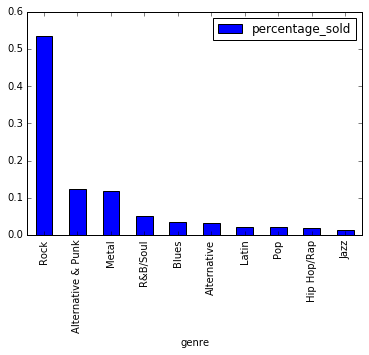

In [10]:
d = run_query(album_query).drop('tracks_sold', axis = 1)
d.plot(kind = 'bar', x = 'genre');

While rock would be the best choice based on this data, choosing three from the four on the list above then the best option is to drop the hip-hop album from the shortlist. 

__Sales Team Performance__

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [11]:
sales_perf_query = """
WITH customer_support_rep_sales AS
    (
    SELECT 
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
    )
    
SELECT 
    e.first_name ||' '|| e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1
"""

run_query(sales_perf_query)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


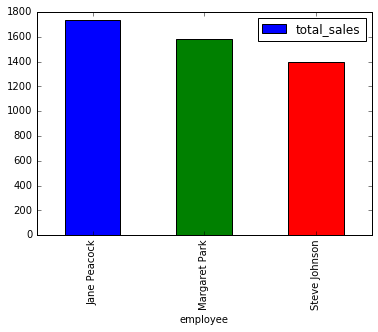

In [12]:
run_query(sales_perf_query).plot(y = 'total_sales', 
                                 x = 'employee', 
                                 kind = 'bar');

The variation in these three sales reps is roughly equivilant to the differences in their term of service with the company.

__Sales By Country__

In [13]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


From the above data the UK, India and Czech Republic show potential for growth. That being said the sample sizes are very small at present.

__Albums vs. Singles Sales__

In [14]:
last_q = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
"""
run_query(last_q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album sales are just under 20% of all sales. 

Opting to have selected tracks only from some or all albumns could put that revenue at risk. 

Unless a growth strategy to outmatch that in the singles catagory is being pursued. 